In [59]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

df = pd.read_csv('dataset.csv')
X = np.array(df[['f1', 'f2']])
y = df['value']


# Input space
x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
# x3 = np.linspace(X[:,2].min(), X[:,2].max()) #p
# x4 = np.linspace(X[:,3].min(), X[:,3].max()) #q

x = (np.array([x1, x2])).T

#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor( n_restarts_optimizer=15)

gp.fit(X, y)

x1x2x3x4 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2x3x4, return_std=True)

# X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
# Zp = np.reshape(y_pred,(50,50))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

# fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111)
#ax.pcolormesh(X0p, X1p, Zp)
# ax = fig.add_subplot(111, projection='3d')            
# surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

# plt.show()

In [80]:
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
print(scipy.__version__)


def costly_function(x):
    total = np.array([])
    for x_i in x:
        total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total + np.random.randn()

def costly_function(x):
    y_pred, MSE = gp.predict(np.array(x), return_std=True)
    return y_pred[0]

1.7.1


In [82]:
x = np.random.randn(5,2)
y = costly_function(x)
print(y)
pd.DataFrame(data={'y':y, 'x0':x[:,0], 'x1':x[:,1]})

7.202818393707275


,y,x0,x1
0,7.202818,-0.105117,-0.370410
1,7.202818,-0.217183,-0.536251
2,7.202818,-0.510719,-0.258487
3,7.202818,0.831480,-0.654888
4,7.202818,-0.854475,0.215617


In [85]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize, rosen, rosen_der
import sys
import pandas as pd

class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp[0]
        
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            bnds = ((0, None), (0, None))
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                # print(np.atleast_1d(x_start).ndim)
                # print(np.array(x_start))
                # input = []
                # for i in x_start:
                #     input.append(i)
                # print(input.ndim)
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B', tol=1e-6)
                if response.fun[0] < min_ei:
                    min_ei = response.fun[0]
                    x_optimal = response.x
            
            return x_optimal, min_ei
    
    def optimize(self):
        from tqdm import tqdm 
        y_max_ind = np.argmax(self.y_init)
        print(y_max_ind)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in tqdm(range(self.n_iter)):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            
            self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
        
        return optimal_x, y_max

In [86]:
from scipy.optimize import minimize

x0=[7.5, 1.1, 1.1, 0.7, 0.7, 0.7, 0.7, -1.0, -0.8]
execMode=2
other_args=[execMode]

def objectiveFunction(x, other_args):
    execMode=other_args[0]
    print(sum(x))
    return sum(x)

solution = minimize(objectiveFunction, x0, method='SLSQP', args=other_args)

10.699999999999996
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
10.700000014901157
1.7
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
1.7000000149011611
-43.300000000000026
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-43.299999985098864
-268.3000000000001
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-268.29999998509896
-1393.300000000001
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-1393.2999999851
-7018.30000000002
-7018.299999985119
-7018.299999985119
-7018.29

In [87]:
np.atleast_1d([1, 2]).ndim


1

In [88]:
x_new = np.array([1, 2])
_get_expected_improvement(x_new)
_acquisition_function(x_new)
#_get_next_probable_point()


array([-0.09908809])

In [89]:
sample_x = np.array([[0.8,0.001],[0.0062,0.53]])
sample_y = costly_function(sample_x)
print(sample_y)

bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=200, scale=10, batch_size=30)
bopt.optimize()

21.646523475646973
0


IndexError: invalid index to scalar variable.

<AxesSubplot:>

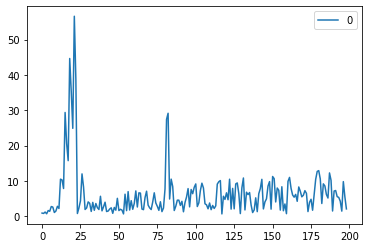

In [54]:
pd.DataFrame(bopt.distances_).plot()

<AxesSubplot:>

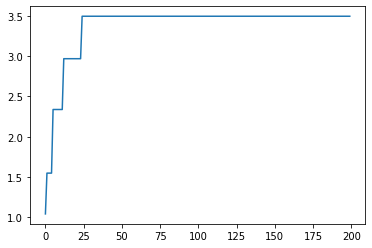

In [55]:
bopt.best_samples_['y'].plot()

<AxesSubplot:>

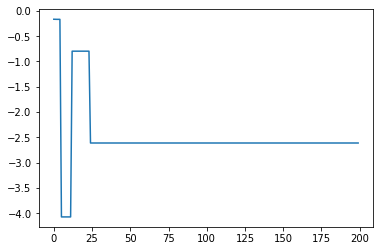

In [56]:
bopt.best_samples_['ei'].plot()